In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from datetime import datetime 
import torch
import random

torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True

In [2]:
data = pd.read_csv('train.csv')
data.shape
#print(data.dtypes)
def process_df_date_time(df:pd.DataFrame):
    output = df.copy()
    output['date'] = pd.to_datetime(output['date'])
    output['date'] = pd.to_datetime(output['date'])
    output['year'] = output['date'].dt.year
    output['month'] = output['date'].dt.month
    output['day'] = output['date'].dt.day
    return output


out = process_df_date_time(data)
out.drop('date',axis=1)
#out.head()

,store,item,sales,year,month,day
0,1,1,13,2013,1,1
1,1,1,11,2013,1,2
2,1,1,14,2013,1,3
3,1,1,13,2013,1,4
4,1,1,10,2013,1,5
...,...,...,...,...,...,...
912995,10,50,63,2017,12,27
912996,10,50,59,2017,12,28
912997,10,50,74,2017,12,29
912998,10,50,62,2017,12,30


In [3]:
storeID = 10
store1 = out[out['store'] == storeID]
store1.head()

,date,store,item,sales,year,month,day
16434,2013-01-01,10,1,14,2013,1,1
16435,2013-01-02,10,1,14,2013,1,2
16436,2013-01-03,10,1,16,2013,1,3
16437,2013-01-04,10,1,17,2013,1,4
16438,2013-01-05,10,1,12,2013,1,5


In [4]:

    
store1_items_sales = [store1[store1['item']==i]['sales'].tolist() for i in range(1,51)]
store1_items_sales = np.array(store1_items_sales)

item_sales = pd.DataFrame()
for i, data in enumerate(store1_items_sales):
    item_sales[f'item_{i+1}_sales'] = data

item_sales.head()


,item_1_sales,item_2_sales,item_3_sales,item_4_sales,item_5_sales,item_6_sales,item_7_sales,item_8_sales,item_9_sales,item_10_sales,...,item_41_sales,item_42_sales,item_43_sales,item_44_sales,item_45_sales,item_46_sales,item_47_sales,item_48_sales,item_49_sales,item_50_sales
0,14,36,18,9,8,32,32,49,23,45,...,12,20,24,17,45,37,11,25,17,33
1,14,34,28,9,13,32,39,38,23,50,...,10,22,29,10,45,33,13,24,13,37
2,16,34,26,14,10,43,38,37,37,53,...,17,27,43,20,56,28,16,29,19,46
3,17,50,31,16,10,50,33,44,28,51,...,13,24,27,12,50,44,11,39,23,51
4,12,42,22,19,13,43,46,58,35,54,...,14,25,31,25,62,45,16,34,22,41


In [5]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# item_sales = scaler.fit_transform(item_sales)

item_sales = item_sales.values

In [6]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [7]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class SeqDataset(Dataset):
    def __init__(self, data, window_size):
        self.window_size = window_size
        self.X, self.Y = sliding_windows(data,window_size)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]


train, test = train_test_split(item_sales, train_size=4/5, shuffle=False)
train_dataset = SeqDataset(train,30)
test_dataset = SeqDataset(test,30)

batch_size = 1

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

#See the shape of 1 batch:
tx, ty = next(iter(train_loader))
print(tx.shape,ty.shape)

print(tx)
print(ty)

        

torch.Size([1, 30, 50]) torch.Size([1, 50])
tensor([[[14, 36, 18,  ..., 25, 17, 33],
         [14, 34, 28,  ..., 24, 13, 37],
         [16, 34, 26,  ..., 29, 19, 46],
         ...,
         [12, 32, 12,  ..., 31, 16, 34],
         [14, 44, 20,  ..., 25, 14, 36],
         [17, 37, 13,  ..., 23, 18, 40]]], dtype=torch.int32)
tensor([[ 5, 39, 18, 13, 13, 37, 25, 49, 43, 48, 48, 46, 58, 45, 56, 16, 13, 56,
         31, 31, 26, 39, 21, 35, 49, 20, 14, 64, 44, 24, 48, 18, 43, 23, 44, 38,
         21, 44, 29, 24, 19, 22, 34, 19, 46, 44, 12, 34, 22, 43]],
       dtype=torch.int32)


In [8]:
import torch.nn as nn
import torch
from torch import Tensor
from torch.autograd import Variable

class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.cnn = nn.Conv1d(50,64, kernel_size=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.cnn2 = nn.Conv1d(64, 64, kernel_size=2)


        self.l2 = nn.Linear(384,50)

        #self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        output = self.cnn(x)
        output = self.relu(output)
        output = self.maxpool(output)
        output = self.cnn2(output)
        output = self.relu(output)
        output = self.maxpool(output)
        output = output.permute(0,2,1)


        output = output.flatten()

        output = self.l2(output)
        return output


cnn_model = CNN()
cnn_model.cuda()
print(cnn_model)

CNN(
  (cnn): Conv1d(50, 64, kernel_size=(2,), stride=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
  (l2): Linear(in_features=384, out_features=50, bias=True)
)


In [9]:
num_epochs = 100
learning_rate = 0.00001

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

min_loss = 9999
stop_count = 0
# Train the model
for epoch in range(num_epochs):

    steps = 0
    epoch_loss = 0
    cnn_model.train()

    for X, Y in train_loader:
        
        steps += 1
        X = X.float().cuda()
        Y = Y.float().cuda()
        X = X.permute(0,2,1)    
        outputs = cnn_model(X)
        optimizer.zero_grad()
        
        # obtain the loss function
        outputs = outputs.squeeze(0)
        loss = torch.sqrt(criterion(outputs, Y.squeeze(0)))
        epoch_loss += loss.item()
        
        loss.backward()
        
        optimizer.step()
        if steps % 200 == 0:
            print("Epoch: %d, step%d loss: %1.5f" % (epoch, steps, loss.item()))

    mse = []
    cnn_model.eval()
    with torch.no_grad():
        for X, Y in test_loader:
            X = X.float().cuda()
            Y = Y.float().cuda()
            out = cnn_model(X.permute(0,2,1))
            out = out.squeeze(0)
            loss = torch.sqrt(criterion(out, Y.squeeze(0)))
            mse.append(loss.item())
            out = out.tolist()
    avg_val_mean = np.mean(mse)
    print(f'Train loss: {epoch_loss/len(train_loader)}, Validation loss: ',avg_val_mean)
    if avg_val_mean < min_loss: 
        print(f'Current loss better than previous loss of {min_loss}, saving model...')
        min_loss = avg_val_mean
        torch.save(cnn_model.state_dict,f'cnn_model_{storeID}')
        stop_count = 0
    else:
        stop_count += 1
        if stop_count > 7: break


Epoch: 0, step200 loss: 57.93110
Epoch: 0, step400 loss: 28.43547
Epoch: 0, step600 loss: 12.20757
Epoch: 0, step800 loss: 12.32488
Epoch: 0, step1000 loss: 10.54155
Epoch: 0, step1200 loss: 11.71702
Epoch: 0, step1400 loss: 9.41569
Train loss: 21.088474497251198, Validation loss:  13.452230128957265
Current loss better than previous loss of 9999, saving model...
Epoch: 1, step200 loss: 12.22629
Epoch: 1, step400 loss: 11.32937
Epoch: 1, step600 loss: 14.22182
Epoch: 1, step800 loss: 12.77561
Epoch: 1, step1000 loss: 10.56169
Epoch: 1, step1200 loss: 11.87988
Epoch: 1, step1400 loss: 9.33503
Train loss: 11.36757565412261, Validation loss:  13.370428486724398
Current loss better than previous loss of 13.452230128957265, saving model...
Epoch: 2, step200 loss: 12.18661
Epoch: 2, step400 loss: 11.29170
Epoch: 2, step600 loss: 14.21514
Epoch: 2, step800 loss: 12.71749
Epoch: 2, step1000 loss: 10.56904
Epoch: 2, step1200 loss: 11.83876
Epoch: 2, step1400 loss: 9.26569
Train loss: 11.3248998

In [10]:
cnn_model.cpu()
results = []
mse = []
test_y = []
cnn_model.eval()
shown_model = False
with torch.no_grad():
    for X, Y in test_loader:
        X = X.float()
        Y = Y.float()            
        out = cnn_model(X.permute(0,2,1))
        out = out.squeeze(0)
        loss = torch.sqrt(criterion(out,Y))
        test_y.append(Y.squeeze(0).tolist())
        #print(out,Y)
        mse.append(loss.item())
        out = out.squeeze(0).tolist()
        results.append(out)

index = 25
results = np.array(results)
test_y = np.array(test_y)
print(results.shape, test_y.shape)
print(np.mean(mse))




(335, 50) (335, 50)
9.771484532996789


C:\Users\Lai Ming Hui\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1, 50])) that is different to the input size (torch.Size([50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [11]:
test_y = test_y.transpose(1,0)
print(results.shape)
results = results.transpose(1,0)
print(results.shape,test_y.shape)

(335, 50)
(50, 335) (50, 335)


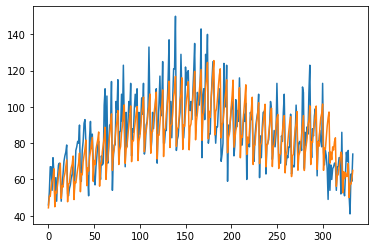

In [12]:
combined = [p for p in zip(test_y[-1][:-1],results[-1][:-1])]
plt.plot(combined)

In [13]:
data = item_sales
next_three_months = []
cnn_model.eval()
future_preds = []

for i in range(30,len(data)):
    input = Tensor(data[i-30:i]).unsqueeze(0)
    pred = input.permute(0,2,1)
    pred = cnn_model(pred)
    pred_out = np.array(pred.tolist())
    future_preds.append(pred_out)


future_preds = np.array(future_preds)
future_preds = future_preds.transpose(1,0)
print(future_preds.shape)

(50, 1796)


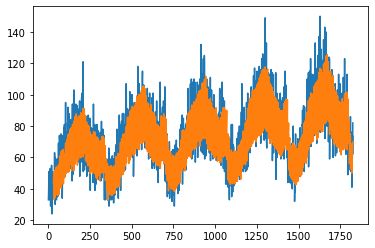

In [14]:
x_range = range(len(data))
plt.plot(x_range, data.transpose(1,0)[-1])
plt.plot(x_range[30:],future_preds[-1])


In [15]:
data = item_sales
cnn_model.eval()
next_three_months = []
for i in range(90):
    input = Tensor(data[-30:]).unsqueeze(0)
    pred = input.permute(0,2,1)
    pred = cnn_model(pred)
    pred_out = np.array(pred.tolist())
    data=np.vstack([data,pred_out])
    next_three_months.append(pred_out)

next_three_months = np.array(next_three_months)    

(50, 1826) (50, 1916)


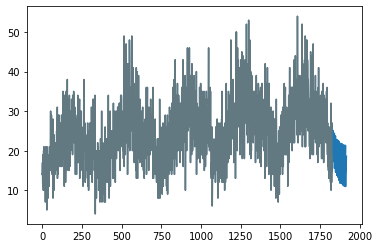

In [16]:
original = item_sales


o = original.transpose(1,0)
d = data.transpose(1,0)

print(o.shape, d.shape)
plt.plot(d[0])

plt.plot(o[0],alpha=0.3)
plt.show()

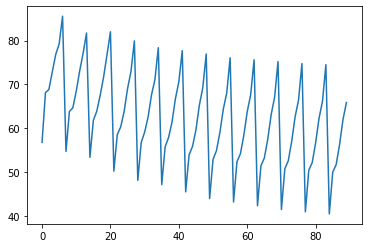

In [17]:
next_three_months = next_three_months.transpose(1,0)
plt.plot(next_three_months[24])
plt.show()

In [18]:
next_three_months_flat = next_three_months.flatten()
print(next_three_months_flat.shape)


(4500,)


In [19]:
test_df = pd.read_csv('test.csv')
test_df = process_df_date_time(test_df)
test_store_1 = test_df[test_df['store']==storeID]
test_store_1['sales'] = next_three_months_flat
test_store_1 = test_store_1[['id','sales']] 
test_store_1.to_csv(f'store{storeID}.csv')

C:\Users\LAIMIN~1\AppData\Local\Temp/ipykernel_5924/2073702483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_store_1['sales'] = next_three_months_flat
